In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

#########################South Dakota Functions###########################
# read SD data (accident + person) from file path, return df
def make_SD(year):
    sd_year_p = pd.read_csv("Person"+str(year)+".txt",sep="|")
    sd_year_a = pd.read_csv("Accident"+str(year)+".txt",sep="|")
    sd_year_a = sd_year_a[['AccidentSeqID','AccidentDateTime']]
    sd_year_p = sd_year_p[["AccidentSeqID","DrugUseDesc",'AlcoholUseDesc']]
    sd_year = pd.merge(left=sd_year_a,right=sd_year_p,on='AccidentSeqID')
    sd_year["YEAR"] = year
    return sd_year

# clean SD df and create useful columns for identifying DUI etc.
def clean_SD(df,year):
    copy = df.copy(deep=True)
    copy['DRUG'] = copy.DrugUseDesc.apply(lambda x:1 if x == 'Drugs used' else 0)
    copy['ALCOHOL'] = copy.AlcoholUseDesc.apply(lambda x:1 if x == 'Alcohol used' else 0)
    copy['DUI'] = copy.apply(lambda x:np.any([x.DRUG,x.ALCOHOL]),axis=1)
    copy['MONTH'] = pd.to_datetime(copy.AccidentDateTime).dt.month
    return copy

# Could get SD data in one df(2015-2018) rather make_SD would produce multiple
def make_all_SD():
    result = []
    for i in range(2015,2019):
        sd_year_p = pd.read_csv("Person"+str(i)+".txt",sep="|")
        sd_year_a = pd.read_csv("Accident"+str(i)+".txt",sep="|")
        sd_year_v = pd.read_csv("Vehicle"+str(i)+".txt",sep="|")
        sd_year_a = sd_year_a[['AccidentSeqID','AccidentDateTime','Severity']]
        sd_year_p = sd_year_p[["AccidentSeqID","DrugUseDesc",'AlcoholUseDesc','InjuryStatusDesc']]
        sd_year_v = sd_year_v[['AccidentSeqID','InitialDamagePoint','MostDamagePoint']]
        sd_year = pd.merge(left=sd_year_a,right=sd_year_p,on='AccidentSeqID')
        sd_year = pd.merge(left=sd_year,right=sd_year_v,on='AccidentSeqID')
        sd_year["YEAR"] = i
        result.append(clean_SD(sd_year,i))
    return pd.concat(result)



In [2]:
import numpy as np
data=make_all_SD()

In [87]:
from datetime import datetime
data['datetime']=data['AccidentDateTime'].apply(lambda x:datetime.strptime(x, "%m/%d/%Y %I:%M:%S %p") )
data['dayofweek']=data['datetime'].apply(lambda x: x.weekday()).map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
data['month']=data['datetime'].apply(lambda x:x.month)
data['hour']=data['datetime'].apply(lambda x:x.hour)
data['day']=data['datetime'].apply(lambda x :x.day)

data['hour']=data['hour'].apply(lambda x:str(x).zfill(2))
drug_sd=data[data['DUI']==1]

In [88]:

heat_sd=drug_sd[['hour','dayofweek','AccidentSeqID']]
restr_data_sd = heat_sd.groupby(['hour','dayofweek']).count()['AccidentSeqID'].unstack()

Text(33.0, 0.5, 'Hour')

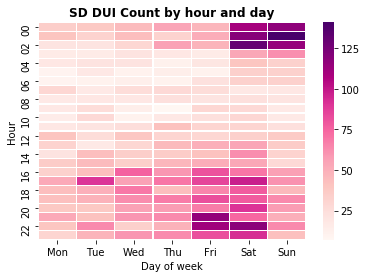

In [90]:
import seaborn as sns
restr_data_sd = restr_data_sd[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]

sns.heatmap(restr_data_sd, cmap="RdPu",linewidth=.25)
plt.title('SD DUI Count by hour and day',fontweight='bold')
plt.xlabel('Day of week')
plt.ylabel('Hour')
#heat_ca.groupby(['COLLISION_TIME','DAY_OF_WEEK']).count()['CASE_ID'].unstack()
#new.groupby(['COLLISION_TIME','DAY_OF_WEEK']).count()['CASE_ID'].unstack()

In [16]:
colli=pd.read_csv('CollisionRecords.txt',sep=',',header=0,error_bad_lines=False)
party=pd.read_csv('PartyRecords.txt',sep=',',header=0,error_bad_lines=False)
new=pd.merge(colli,party, on='CASE_ID',how='right')

b'Skipping line 1667771: expected 76 fields, saw 77\n'


In [17]:
new.dropna(inplace=True, subset=['COLLISION_DATE','ACCIDENT_YEAR'])
new['MONTH']=new.COLLISION_DATE.apply(lambda x:str(int(x))[4:6])
new['YEAR']=new.ACCIDENT_YEAR.astype(int).astype(str)
new['DATE']=new.YEAR.add('-').add(new.MONTH)
new['DATE']=new.DATE.apply(lambda x:datetime.strptime(x,'%Y-%m'))

#new.dropna(subset=['COLLISION_TIME','COLLISION_DATE'],inplace=True)
#new.COLLISION_DATE=new.COLLISION_DATE.astype(int).astype(str)

new.COLLISION_TIME=new.COLLISION_TIME.apply(lambda x:str(int(x)).zfill(4)[0:2])
#new=new[new['COLLISION_TIME']<'24:00']
#new.COLLISION_TIME=new.COLLISION_TIME.apply(lambda x:datetime.strptime(x,'%H:%M'))
new.DAY_OF_WEEK=new.DAY_OF_WEEK.map({1:'Mon',2:'Tue',3:'Wed',4:'Thu',5:'Fri',6:'Sat',7:'Sun'})

#drug.COLLISION_TIME=drug.COLLISION_TIME.map({'00':'12AM','01':'1AM','02':'2AM','03':'3AM','04':'4AM','05':'5AM','06':'6AM','07':'7AM','08':'8AM','09':'9AM','10':'10AM','11':'11AM','12':'12PM','13':'1PM','14':'2PM','15':'3PM','16':'4PM','17':'5PM','18':'6PM','19':'7PM','20':'8PM','21':'9PM','22':'10PM','23':'11PM'})
#new['COLLISION_TIME']=new.COLLISION_TIME.apply(lambda x :x.hour)

drug=new[new['PARTY_DRUG_PHYSICAL']=='E']
drug.dropna(subset=['COLLISION_TIME','COLLISION_DATE'],inplace=True)
drug.COLLISION_DATE=drug.COLLISION_DATE.astype(int).astype(str)

#drug.COLLISION_TIME=drug.COLLISION_TIME.apply(lambda x:str(int(x)).zfill(4)[0:2]+':00')
#drug=drug[drug['COLLISION_TIME']<'24:00']
#drug.COLLISION_TIME=drug.COLLISION_TIME.apply(lambda x:datetime.strptime(x,'%H:%M'))


#drug['COLLISION_TIME']=drug.COLLISION_TIME.dt.time
heat_ca=drug[['COLLISION_TIME','DAY_OF_WEEK','CASE_ID']]

restr_data_ca = heat_ca.groupby(['COLLISION_TIME','DAY_OF_WEEK']).count()['CASE_ID'].unstack()

# Reordering columns
restr_data_ca = restr_data_ca[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
drug_ca=drug

Text(33.0, 0.5, 'Year')

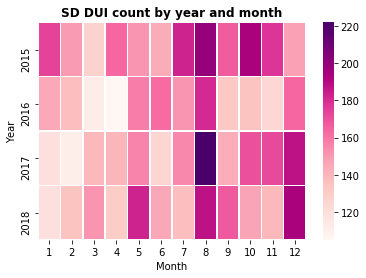

In [91]:
heat4=drug_sd[['month','YEAR','AccidentSeqID']]
restr_data4 = heat4.groupby(['YEAR','month']).count()['AccidentSeqID'].unstack()

# Reordering columns
#restr_data2 = restr_data2[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
restr_data4=restr_data4.iloc[0:4]
sns.heatmap(restr_data4, cmap="RdPu",linewidths=.5)
plt.title('SD DUI count by year and month',fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Year')

In [72]:
from pylab import *

cmap = cm.get_cmap('RdPu', 50)    # 需要几个颜色就写多少

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    hexc=matplotlib.colors.rgb2hex(rgb)
    print(matplotlib.colors.rgb2hex(rgb))

#fff7f3
#fff3ef
#feefec
#feece8
#fee8e5
#fde4e1
#fde0dd
#fddcd9
#fdd8d4
#fdd3cf
#fccfcb
#fccbc6
#fcc6c1
#fcc0bf
#fbbabd
#fbb4bb
#fbaeb9
#faa8b7
#faa1b6
#fa99b3
#f990b0
#f987ac
#f87ea9
#f875a6
#f76ca3
#f564a0
#f15b9f
#ec539d
#e84a9b
#e4429a
#e03998
#da3195
#d22991
#cb208d
#c31889
#bb1085
#b40781
#ac017e
#a3017d
#9b017b
#92017a
#8a0179
#810178
#790177
#710175
#690172
#610070
#59006e
#51006c
#49006a


In [23]:
dic={'No injury':'property damage only','Wild animal hit':'property damage only','Possible':'complaint of pain','Non-incapacitating':
                  'other visible injury','Fatal injury':'fatal','Incapacitating':'severe injury'}
data['type of injury']=data['InjuryStatusDesc'].map(dic)
drug_sd=data[data['DUI']==1]

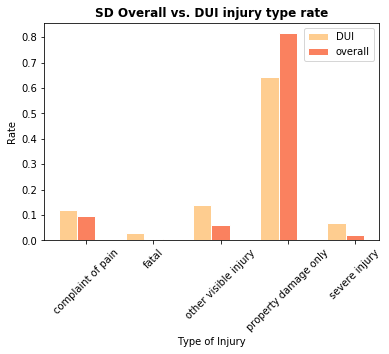

In [102]:
barWidth = 0.27
 
# set height of bar
bars0 = (drug_sd.groupby('type of injury')['AccidentSeqID'].count()/len(drug_sd))
bars1 = (data.groupby('type of injury')['AccidentSeqID'].count()/len(data))


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars0, color='#fecd90', width=barWidth, edgecolor='white', label='DUI')
plt.bar(r2, bars1, color='#fa815f', width=barWidth, edgecolor='white', label='overall')
 
# Add xticks on the middle of the group bars
plt.xlabel('type of injury')
plt.xticks([r + barWidth for r in range(len(bars1))],bars0.index.tolist())
plt.xticks(rotation=45)
# Create legend & Show graphic
##942c80
plt.legend()
plt.ylabel('Rate')
plt.xlabel('Type of Injury')
plt.title('SD Overall vs. DUI injury type rate',fontweight='bold')
plt.show()

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

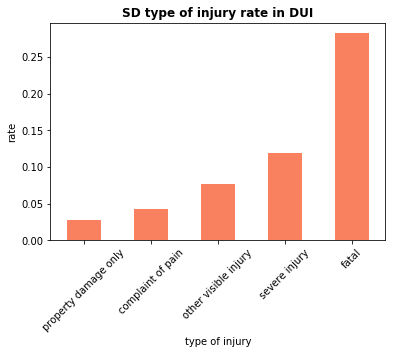

In [37]:
sev=(drug_sd.groupby(['type of injury'])['AccidentSeqID'].count()/data.groupby(['type of injury'])['AccidentSeqID'].count())
#sev.index=['property damage only','fatal','severe injury','other visible injury','complaint of pain']
sev.sort_values().plot(kind='bar', color='#fa815f')
plt.title('SD type of injury rate in DUI',fontweight='bold')
plt.ylabel('rate')
plt.xticks(rotation=45)


In [51]:
data.InitialDamagePoint.unique()
dicc={'Front':'Rear End', 'Left Front':'Head-On', 'Left Rear':'Rear End', 'Wild animal hit':'Hit Object',
       'Mid Left Front':'Broadside', 'Right Front':'Broadside', 'Left Middle':'Sideswipe', 'Right Rear':'Rear End',
       'Right Middle':'Sideswipe', 'Mid Right Front':'Broadside', 'Rear':'Rear End', 'Non-collision':np.nan,
       'Not applicable':np.nan, 'No damage':np.nan, 'Mid Left Rear':'Broadside', 'Undercarriage':'Overturned',
       'Mid Right Rear':'Sideswipe','Top ( roof )':'Overturned', 'Unknown':'Not Stated', 'Not reported':'Not Stated'}
data['type of collision']=data.InitialDamagePoint.map(dicc)


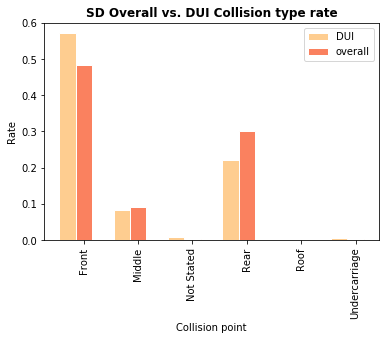

In [101]:
barWidth = 0.30
 
# set height of bar
bars0 = (drug_sd.groupby('Damage point')['AccidentSeqID'].count()/len(drug_sd))
bars1 = (data.groupby('Damage point')['AccidentSeqID'].count()/len(data))#.drop('Wild animal hit')


# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars0, color='#fecd90', width=barWidth, edgecolor='white', label='DUI')
plt.bar(r2, bars1, color='#fa815f', width=barWidth, edgecolor='white', label='overall')
 
# Add xticks on the middle of the group bars
plt.xlabel('Collision point')
plt.xticks([r + barWidth for r in range(len(bars1))],bars0.index.tolist())
plt.xticks(rotation=90)
plt.title('SD Overall vs. DUI Collision type rate',fontweight='bold')
plt.ylabel('Rate')
# Create legend & Show graphic
plt.legend()
plt.show()



Text(0, 0.5, 'Rate')

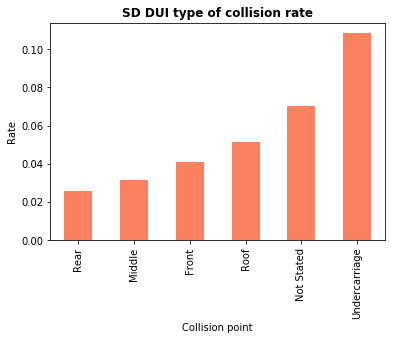

In [97]:
data.InitialDamagePoint.unique()
dicc={'Front':'Front', 'Left Front':'Front', 'Left Rear':'Rear', 'Wild animal hit':np.nan,
       'Mid Left Front':'Front', 'Right Front':'Front', 'Left Middle':'Middle', 'Right Rear':'Rear',
       'Right Middle':'Middle', 'Mid Right Front':'Middle', 'Rear':'Rear', 'Non-collision':np.nan,
       'Not applicable':np.nan, 'No damage':np.nan, 'Mid Left Rear':'Rear', 'Undercarriage':'Undercarriage',
       'Mid Right Rear':'Rear','Top ( roof )':'Roof', 'Unknown':'Not Stated', 'Not reported':'Not Stated'}
data['Damage point']=data.InitialDamagePoint.map(dicc)
drug_sd=data[data['DUI']==1]
(drug_sd.groupby('Damage point')['AccidentSeqID'].count()/data.groupby('Damage point')['AccidentSeqID'].count()).sort_values().plot(kind='bar',color='#fa815f')
plt.title('SD DUI type of collision rate',fontweight='bold')
plt.xlabel('Collision point')
plt.ylabel('Rate')

Text(0, 0.5, 'Rate')

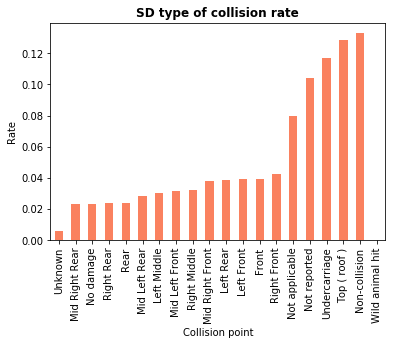

In [94]:
(drug_sd.groupby('MostDamagePoint')['AccidentSeqID'].count()/data.groupby('MostDamagePoint')['AccidentSeqID'].count()).sort_values().plot(kind='bar',color='#fa815f')
plt.title('SD type of collision rate',fontweight='bold')
plt.xlabel('Collision point')
plt.ylabel('Rate')

In [104]:
severe=drug_sd.groupby(['YEAR','type of injury'])['AccidentSeqID'].count()
severe.unstack(level=0)
severe2=data.groupby(['YEAR','type of injury'])['AccidentSeqID'].count()
severe=severe/severe2

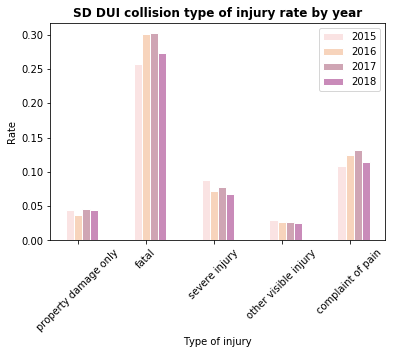

In [107]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.12
 
# set height of bar
bars0 = severe[2015]
bars1 = severe[2016]
bars2 = severe[2017]
bars3 = severe[2018]
#bars4 = severe[2019]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
#r5 = [x + barWidth for x in r4]
 
# Make the plot
plt.bar(r1, bars0, color='#FAE3E3', width=barWidth, edgecolor='white', label='2015')
plt.bar(r2, bars1, color='#F7D4BC', width=barWidth, edgecolor='white', label='2016')
plt.bar(r3, bars2, color='#CFA5B4', width=barWidth, edgecolor='white', label='2017')
plt.bar(r4, bars3, color='#C98BB9', width=barWidth, edgecolor='white', label='2018')
#plt.bar(r5, bars4, color='#846B8A', width=barWidth, edgecolor='white', label='2019')


 
# Add xticks on the middle of the group bars
plt.xlabel('Type of injury')
plt.ylabel('Rate')
plt.title('SD DUI collision type of injury rate by year',fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['property damage only','fatal','severe injury','other visible injury','complaint of pain'])
plt.xticks(rotation=45)
# Create legend & Show graphic
plt.legend()
plt.show()

    